# Seismic Noise Spectrum Modification and Modeling

In [1]:
import pickle

import control
import numpy as np
import matplotlib.pyplot as plt
import scipy

import kontrol


f = np.linspace(1e-3, 1e2, 1024*512)
def noise_model(f, na, nb, a, b):
    return np.sqrt((na/f**a)**2 + (nb/f**b)**2)
n_geophone = noise_model(f, na=1*10**-5.46, nb=1*10**-5.23, a=3.5, b=1)

# Let's assume seismometer is 2 times less noisy than geophone.
n_seismometer = n_geophone / 2

# Generate time series measurements
np.random.seed(1)
t, seismometer_noise = kontrol.spectral.asd2ts(n_seismometer, f=f)

# Ground motion
s = control.tf("s")
wn = 0.15*2*np.pi  # Secondary microseism
q = 10
ground_motion_tf = 0.1 * wn**2 / (s**2+wn/q*s+wn**2)

# Generate time series measurements
fs = 1/(t[1]-t[0])
u = np.random.normal(loc=0, scale=np.sqrt(fs/2), size=len(t))
_, ground_motion = control.forced_response(ground_motion_tf, U=u, T=t)

# Obtain the measured spectral densities.
f_, p_seismic = scipy.signal.welch(ground_motion, fs=fs, nperseg=int(len(t)/5))
_, p_seismometer = scipy.signal.welch(seismometer_noise, fs=fs, nperseg=int(len(t)/5))

Text(0.5, 0, 'Frequency (Hz)')

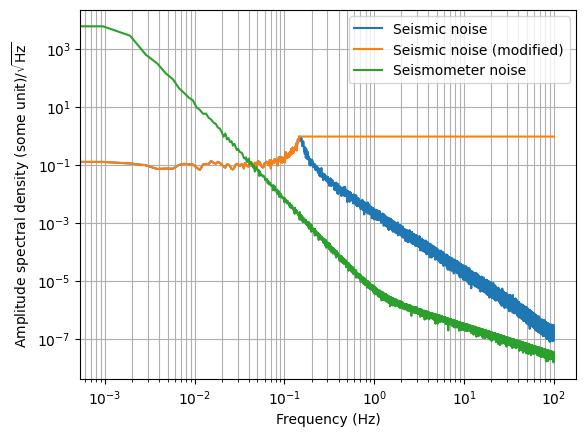

In [2]:
seismic_modified = kontrol.spectral.pad_above_maxima(p_seismic**0.5, order=7500)
# order is passed to scipy.signal.argrelmax() which is used to determine the local maxima. Keep increasing until it works.

plt.loglog(f_, p_seismic**0.5, label="Seismic noise")
plt.loglog(f_, seismic_modified, label="Seismic noise (modified)")
plt.loglog(f_, p_seismometer**0.5, label="Seismometer noise")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

In [3]:
# We don't need to fit the whole spectrum because the modified
# spectrum is flat all the way above the microseism frequency.
# Let's get rid of the data above 1 Hz.
# Data to be modelled:
ydata = seismic_modified[(f_>0) & (f_<1)]
xdata = f_[(f_>0) & (f_<1)]
order = 3
tf_seismic = kontrol.curvefit.spectrum_fit(xdata, ydata, nzero=order, npole=order)

Text(0.5, 0, 'Frequency (Hz)')

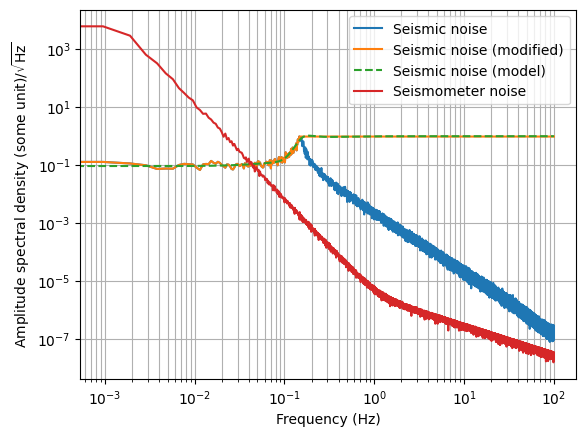

In [4]:
plt.loglog(f_, p_seismic**0.5, label="Seismic noise")
plt.loglog(f_, seismic_modified, label="Seismic noise (modified)")
plt.loglog(f_, abs(tf_seismic(1j*2*np.pi*f_)), "--", label="Seismic noise (model)")
plt.loglog(f_, p_seismometer**0.5, label="Seismometer noise")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

In [5]:
# Export the transfer function model and noise spectrum for future usages.
tf_seismic.save("tf_seismic.pkl")

with open("noise_spectrum_seismic.pkl", "wb") as fh:
    pickle.dump(p_seismic**0.5, fh)
with open("noise_spectrum_seismometer.pkl", "wb") as fh:
    pickle.dump(p_seismometer**0.5, fh)
with open("noise_spectrum_frequency.pkl", "wb") as fh:
    pickle.dump(f_, fh)